### 1. import EVERYTHING

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 

import psycopg2
import random
from matplotlib import pyplot

### 2. useful functions

In [8]:
def RemoveStopWordsTitle(df):
    #removes a list of stop words from the text
    #text must be in the second column
    for i in range(len(df.index)):
        if i%1000 == 0: print i # just to make sure its working
        query = df.iloc[i,1]
        querywords = query.split()
        resultwords = [word for word in querywords if word.lower() not in stopwords]
        df.iloc[i,1] = ' '.join(resultwords)

    
def Stemmer(df):
    #stemmer for all text
    #text must be in the second column
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    for i in range(len(df.index)):
        query = df.iloc[i,1]
        querywords = query.split()
        resultwords = [stemmer.stem(word) for word in querywords]            
        df.iloc[i,1] = ' '.join(resultwords)

        
def statusUpdate(df):
    if df['status'] == 5: 
        return 1
    else: 
        return 0

### 3. read the data

In [104]:
conn = psycopg2.connect(database="spacex_forecast", user="postgres", password="", host="127.0.0.1", port="5432")

articles = pd.read_sql_query("""select * from ag_topic, article where 
                        intake_date between '6/21/2017' and '6/24/2017' and
                         ag_topic.article_group_id = article.article_group_id and media_type = 1 and
                         status not in (5)""", con=conn)

articles_released = pd.read_sql_query("""select * from ag_topic, article where 
                        intake_date between '6/1/2017' and '6/24/2017' and
                         ag_topic.article_group_id = article.article_group_id and media_type = 1 and
                         status = 5""", con=conn)

articles = articles.append(articles_released)

In [62]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272861 entries, 0 to 12616
Data columns (total 8 columns):
article_group_id    272861 non-null int64
topic_id            272861 non-null int64
status              272861 non-null int64
article_id          272861 non-null int64
article_group_id    272861 non-null int64
intake_date         272861 non-null datetime64[ns]
body                272861 non-null object
media_type          272861 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 18.7+ MB


### An attempt to reduce 1st past filter problem with a different client's dataset

#### this did not have good results

In [105]:
nwconn = psycopg2.connect(database="client", user="postgres", password="", host="googlecloud.publicrelay.net", port="5432")
sx = pd.read_sql_query("""    
    SELECT 
        article_id, title, body from article, analysis, media, outlet 
    WHERE analysis.client_id = '1835594405' and 
        article.article_group_id = analysis.article_group_id and 
        article.outlet_id = outlet.outlet_id and 
        outlet.media_id = media.media_id and
        is_primary and media_type = 'Online/Traditional' and
        intake_date between '4/1/2017' and '6/1/2017'""", con=nwconn)


sx['text'] = sx.title + sx.body
sx = sx.drop(['title','body','article_id'],1)
sx

sx['status'] = 1
cols = ['status','text']
sx[cols]

,status,text
0,1,Arianespace Confirms Summer Launch Dates for V...
1,1,The Wizards From Oz: How Two Aussies Made Bill...
2,1,Award honors former astronaut Piers Sellers fo...
3,1,"Elon Musk's SpaceX Launches Spy Satellite, Bre..."
4,1,Our champ is building an industry; our chump i...
5,1,Waco housing boom leaves its mark on tax appra...
6,1,SpaceX May Send Two Dragon Landers to Mars in ...
7,1,Amazon Looks More and More Like a Tilt-A-Whirl...
8,1,Elon Musk Says He'll Leave Presidential Counci...
9,1,Blue Origin rockets lift off on $1B a year fro...


In [106]:
articles = articles.drop(['index'],1)
articles = articles.drop_duplicates('article_id', keep='first')
articles = articles.drop(['article_group_id','topic_id','article_id','intake_date'],1)


    
articles['status'] = articles.apply(lambda articles: statusUpdate(articles), axis=1)
articles = articles.rename(index=str, columns={"body": "text"})
articles = articles[articles['media_type'] == 1]
articles = articles.drop(['media_type'], 1)
articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11842 entries, 0 to 12132
Data columns (total 2 columns):
status    11842 non-null int64
text      11842 non-null object
dtypes: int64(1), object(1)
memory usage: 277.5+ KB


In [107]:
articles = articles.append(sx)
articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13023 entries, 0 to 1180
Data columns (total 2 columns):
status    13023 non-null int64
text      13023 non-null object
dtypes: int64(1), object(1)
memory usage: 305.2+ KB


In [108]:
articles = articles.sample(frac=1).reset_index(drop=True)

### Remove funky characters since we're not using a stemmer

In [110]:
RemoveStopWordsTitle(articles)
articles['text'] = articles['text'].str.replace('\n', '')
articles['text'] = articles['text'].str.replace(',', '')
articles['text'] = articles['text'].str.replace('.', '')
articles['text'] = articles['text'].str.replace('"', '')
articles['text'] = articles['text'].str.replace('-', '')
articles['text'] = articles['text'].str.replace(':', '')

%time articles['text'] = articles["text"].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
articles.groupby('status').describe()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
CPU times: user 8.22 s, sys: 43.2 ms, total: 8.26 s
Wall time: 8.28 s


text                                                               
        count unique                                                top freq
status                                                                      
0       11220  11114                                                 __   12
1        1803   1800  SpaceX set big days Friday Elon Muskfounded co...    2

In [111]:
articles = articles[articles.text.str.contains('Terms established provider content') == False]

### Find length of articles and see if there is a difference between released vs unreleased

In [112]:
articles['length'] = articles['text'].map(lambda text: len(text))

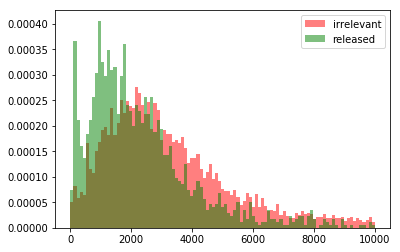

In [113]:
x = articles[articles['status']==1]['length']
y = articles[articles['status']==0]['length']

bins = numpy.linspace(0, 10000, 100)

pyplot.hist(y, bins, alpha=0.5, label='irrelevant', normed=True, color='red')
pyplot.hist(x, bins, alpha=0.5, label='released', normed=True, color='green')

pyplot.legend(loc='upper right')
pyplot.show()

In [114]:
a = articles[articles['length'] < 10000]
print a[a['status'] == 1].describe()
print
print a[a['status'] == 0].describe()

def split_into_tokens(article):
    article = unicode(article, 'utf8')  # convert bytes into proper unicode
    return TextBlob(article).words

articles.text.head().apply(split_into_tokens)

def split_into_lemmas(article):
    article = unicode(article, 'utf8').lower()
    words = TextBlob(article).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

articles.text.head().apply(split_into_lemmas)

       status       length
count  1732.0  1732.000000
mean      1.0  2306.406467
std       0.0  1753.487303
min       1.0     0.000000
25%       1.0  1073.000000
50%       1.0  1885.000000
75%       1.0  3013.250000
max       1.0  9964.000000

        status        length
count  10300.0  10300.000000
mean       0.0   3195.972718
std        0.0   2038.824904
min        0.0      2.000000
25%        0.0   1718.000000
50%        0.0   2765.000000
75%        0.0   4226.000000
max        0.0   9999.000000


0    [20170623, 1626, nehemiah, security, internati...
1    [chef, worth, weight, cooking, pasta, al, dent...
2    [mar, society, founder, blast, nasa, 'worst, p...
3    [andrej, karpathy, world, 's, leading, expert,...
4    [jim, cramer, splash, tequila, space, track, t...
Name: text, dtype: object

In [ ]:
"""
%time bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(articles['text'])
print len(bow_transformer.vocabulary_)

%time articles_bow = bow_transformer.transform(articles['text'])
print 'sparse matrix shape:', articles_bow.shape
print 'number of non-zeros:', articles_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * articles_bow.nnz / (articles_bow.shape[0] * articles_bow.shape[1]))
"""

In [60]:
articles

,status,text,length
7173,1,,0
9331,0,...,931
9748,0,...,918
8338,0,Introdu...,2955
5904,0,Advertisement Boeing C...,1765
8445,0,Advertisement Boeing C...,1730
2991,0,Advertisement Lockheed...,2095
5807,0,Advertisement Lockheed...,1996
4272,0,Advertisement market c...,3278
8037,0,Mashable 201...,1897


### split into training and test sets

In [115]:
articles = articles.sort_values(['text'])
msg_train, msg_test, label_train, label_test = \
    train_test_split(articles['text'], articles['status'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

10388 2598 12986


### CV plotting function

In [116]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Define the pipeline of transformations

In [ ]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC(probability=True, class_weight='balanced')),
])

# kernel='linear', C=10.0, 

# pipeline parameters to automatically explore and tune
param_svm = [
    #{'classifier__C': [10], 'classifier__kernel': ['linear']}
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']}
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=3),  # what type of cross validation to use
)

### Run it.

In [119]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

CPU times: user 5min 54s, sys: 7.49 s, total: 6min 1s
Wall time: 1h 28min 13s


In [120]:
svm_detector.cv_results_

{'mean_fit_time': array([  380.48154465,   367.96132429,   382.67329168,   407.78443829,
         1015.10519942,  1007.78399197,   788.73730095,  1016.84342933,
          502.49431435,   926.25165526,   525.52397259,   603.22150302]),
 'mean_score_time': array([ 106.52386475,  104.12140536,  105.0940853 ,  106.78368473,
         165.71412659,  169.51409531,  139.39777708,  187.40068897,
         112.24447298,  162.7478354 ,  131.41000962,   98.9086837 ]),
 'mean_test_score': array([ 0.95764343,  0.95947247,  0.95976126,  0.95552561,  0.76501733,
         0.62148633,  0.94204852,  0.77185214,  0.94763188,  0.94185599,
         0.96053138,  0.94772815]),
 'mean_train_score': array([ 0.98464574,  0.99947055,  0.99990374,  0.99971123,  0.77080297,
         0.621606  ,  0.94546586,  0.77773338,  0.96365995,  0.94546586,
         0.99330959,  0.96365995]),
 'param_classifier__C': masked_array(data = [1 10 100 1000 1 1 10 10 100 100 1000 1000],
              mask = [False False False False Fa

In [121]:
%time print confusion_matrix(label_test, svm_detector.predict(msg_test))
%time print classification_report(label_test, svm_detector.predict(msg_test))

#print confusion_matrix(label_train, svm_detector.predict(msg_train))
#print classification_report(label_train, svm_detector.predict(msg_train))

[[2192   46]
 [  50  310]]
CPU times: user 36.8 s, sys: 205 ms, total: 37 s
Wall time: 37.1 s
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2238
          1       0.87      0.86      0.87       360

avg / total       0.96      0.96      0.96      2598

CPU times: user 37.1 s, sys: 201 ms, total: 37.3 s
Wall time: 37.4 s


CPU times: user 8.73 s, sys: 5.97 s, total: 14.7 s
Wall time: 50min 31s


<module 'matplotlib.pyplot' from '/Users/elucia/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

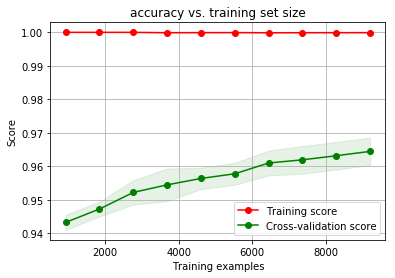

In [ ]:
%time plot_learning_curve(pipeline_svm, "accuracy vs. training set size", msg_train, label_train, cv=5, train_sizes=np.linspace(.1, 1.0, 10))

In [46]:
text = """Buy Photo 

The sale and use of fireworks will be exempt from a new Brevard County burn ban ordinance that county commissioners unanimously approved this week. (Photo: FLORIDA TODAY FILE PHOTO) Buy Photo 

Buy Photo 

Thousands pack Cocoa Beach for fireworks celebrating the 2016 Fourth of July weekend. (Photo: FLORIDA TODAY file) 

While many Brevard County residents looked up to the skies to see colorful fireworks over the last few days, firefighters kept their eyes to the ground scouting for flames the bursts may have caused. 

Brevard County Fire Rescue officials said they responded to 15 fires started by fireworks between Saturday and early Wednesday. Those included small brush fires, tree fires and trash can fires. 

CLOSE 

Today on the News in 90 seconds, SpaceX is hoping to get this rocket off the ground, Vice President Mike Pence will be at KSC tomorrow and fireworks were not to blame for a July Fourth house fire. Video by Luann Manderville and Rob Landers. 7/5/17 

The fires they put out on Tuesday happened on Plum Lane in Mims, Emerald Circle in Merritt Island, Papaya Street in Canaveral Groves, the 7000 block of Grissom Parkway in Port St. John and the corner of Clydesdale Boulveard and Percheron Drive in west Eau Gallie. 

One homeowner on Cedar Lake Drive in central Brevard put out a small fire at his home before firefighters arrived. 

The county has had dry weather the last several days, which may have contributed to the number of fires, Fire Rescue officials said. Previous Independence Days were preceded by more rain; there's been only a trace amount of rain to fall since June 27. 

The county's risk for wildfires increased in the last week, according to the Keetch-Byram drought index, a daily measure of ground moisture to determine how susceptible vegetation could be to catching fire. Wednesday's score was 228 in Brevard on a scale of 800, up 20 percent from Tuesday and nearly 100 points in a week. The higher the number for the index, the higher the risk for brush fires. 

No other fire departments in the county reported any significant fires caused by fireworks.The Florida Forest Service was not called to assist with any Brevard fires Tuesday, spokesman Sean Gallagher said. 

The state Fire Marshal's Office is investigating a fire that destroyed a Satellite Beach home in the 600 block of Carribean Road Tuesday night. Investigators said fireworks were not involved in that blaze. 

Lamaur Stancil is a breaking news reporter for Florida Today and TCPalm.com. He can be reached at 321-242-3662 or 321-987-7179. E-mail him at lamaur.stancil@tcpalm.com. Follow him on Twitter at @TCPalmLStancil. 

Read or Share this story: http://on.flatoday.com/2tS7MTV"""

querywords = text.split()
text = [word for word in querywords if word.lower() not in stopwords]
text = ' '.join(text)
text.replace('\n', '')
text.replace(',', '')
text.replace('.', '')
text.replace('"', '')
text.replace('-', '')
text.replace(':', '')
#%time text = text.apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))


"Buy Photo sale fireworks will exempt Brevard County burn ban ordinance county commissioners unanimously approved week. (Photo FLORIDA TODAY FILE PHOTO) Buy Photo Buy Photo Thousands pack Cocoa Beach fireworks celebrating 2016 Fourth July weekend. (Photo FLORIDA TODAY file) Brevard County residents looked skies colorful fireworks days, firefighters eyes ground scouting flames bursts caused. Brevard County Fire Rescue officials responded 15 fires started fireworks Saturday early Wednesday. included small brush fires, tree fires trash fires. CLOSE Today News 90 seconds, SpaceX hoping rocket ground, Vice President Mike Pence will KSC tomorrow fireworks blame July Fourth house fire. Video Luann Manderville Rob Landers. 7/5/17 fires Tuesday happened Plum Lane Mims, Emerald Circle Merritt Island, Papaya Street Canaveral Groves, 7000 block Grissom Parkway Port St. John corner Clydesdale Boulveard Percheron Drive west Eau Gallie. homeowner Cedar Lake Drive central Brevard small fire firefighte

In [51]:
text = text.encode('string-escape')

In [52]:
svm_detector.predict_proba(text)

ValueError: Iterable over raw text documents expected, string object received.

In [56]:
msg_test

6785           Now I      m introspective critical     ...
8266     Serpentine Galleries Kensington Gardens London...
8890     Gwyneth Paltrow Chris Martin Facebook year maj...
7144     Impression Technologies (ITL) raised   3m Seri...
236      DELHI bid deliver customised experiences mille...
5534     Amazon CEO Jeff Bezos Microsoft CEO Satya Nade...
9431     weekday afternoon March Seattle police officer...
2281     eTN Feature Story Airbus implement fixed deplo...
9802     Renowned astrophysicist Stephen Hawking extrem...
3321     draft pick power rotation player Heat loaded w...
4175     Army opens move adopt softwaredefined datacent...
8907     Credit mashablecom About 1 second ago 0 views ...
12316    Stream Field Investments Ltd subsidiary Singap...
5633     Salute Small BusinessesActing NASA Administrat...
12023    effort free cap space summer Houston Rockets s...
5302     Weingarten Realty Investors (NYSEWRI) assigned...
63       Archives    Counterfeit Lego brand selling ISI.

In [122]:
%time p_test = svm_detector.predict_proba(msg_test)
results = []
for i,j,k,m in zip(label_test, msg_test, range(len(label_test)), p_test):
    result = str(i)+":"+str(round(p_test[k][1], 4))+":"+str(j)
    results.append(result)

CPU times: user 36.7 s, sys: 186 ms, total: 36.9 s
Wall time: 37 s


In [123]:
from sqlalchemy import create_engine
engine = create_engine('postgresql+psycopg2://postgres@localhost/spacex_forecast')
df_results.to_sql('classification_results4', engine)

In [124]:
df_results = pd.DataFrame(results)

df_results['label'] = df_results[0].str.split(":").str.get(0)
df_results['prediction'] = df_results[0].str.split(":").str.get(1)
#df_results['classfication'] = df_results[0].str.split(":").str.get(2)
df_results['text'] = df_results[0].str.split(":").str.get(2)
df_results = df_results.drop([0],1)
df_results.sort_values('prediction', ascending=True)
df = df_results.sort_values('prediction', ascending=False).reset_index()

In [137]:
for i in (0.008, 0.01, 0.025, .05, .1, .15, .2, .25, .3, .35, .4):
    split = i
    print "probability score:         " + str(split)

    test = df[df['label']==1]
    test = test[test['prediction'] < split].reset_index()
    print "postitive articles missed: " + str(len(test))

    test = df[df['label']==0]
    test = test[test['prediction'] > split]
    print "negative articles seen:    " + str(len(test))
    print

probability score:         0.008
postitive articles missed: 0
negative articles seen:    996

probability score:         0.01
postitive articles missed: 1
negative articles seen:    870

probability score:         0.025
postitive articles missed: 5
negative articles seen:    390

probability score:         0.05
postitive articles missed: 11
negative articles seen:    231

probability score:         0.1
postitive articles missed: 19
negative articles seen:    134

probability score:         0.15
postitive articles missed: 21
negative articles seen:    100

probability score:         0.2
postitive articles missed: 30
negative articles seen:    78

probability score:         0.25
postitive articles missed: 34
negative articles seen:    66

probability score:         0.3
postitive articles missed: 40
negative articles seen:    60

probability score:         0.35
postitive articles missed: 43
negative articles seen:    53

probability score:         0.4
postitive articles missed: 50
negativ

In [33]:
for i in range(len(test)):
    print test['text'][i]
    print "-------------------------------"

KeyError: 0

In [128]:
df['label'] = df['label'].map(float)
#df = df.drop(['index'],1)
df['prediction'] = df['prediction'].map(float)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x182c20c10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x182d33590>], dtype=object)

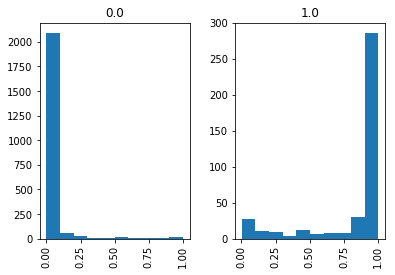

In [32]:
#articles.hist(column='length', by='status', bins=50, range=(0,10000))
df.hist(column='prediction', by='label', bins=10)

In [82]:
"""
df = pd.read_sql_query(""" select * from classification_results""", con=conn)
df.info()
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 4 columns):
index         2373 non-null int64
label         2373 non-null object
prediction    2373 non-null object
text          2373 non-null object
dtypes: int64(1), object(3)
memory usage: 74.2+ KB


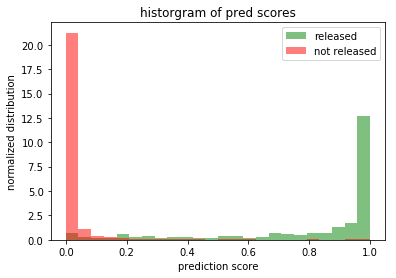

In [133]:
x = df[df['label']==1]['prediction']
y = df[df['label']==0]['prediction']

bins = numpy.linspace(0, 1, 25)

pyplot.hist(x, bins, alpha=0.5, label='released', normed=True, color='green')
pyplot.hist(y, bins, alpha=0.5, label='not released', normed=True, color='red')
plt.xlabel('prediction score')
plt.ylabel('normalized distribution')
plt.title('historgram of pred scores')
pyplot.legend(loc='upper right')
pyplot.show()

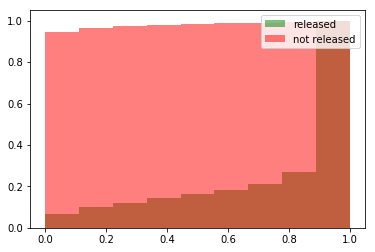

In [38]:
x = df[df['label']==1]['prediction']
y = df[df['label']==0]['prediction']

bins = numpy.linspace(0, 1, 10)

pyplot.hist(x, bins, alpha=0.5, label='released', normed=True, color='green', cumulative=True)
pyplot.hist(y, bins, alpha=0.5, label='not released', normed=True, color='red', cumulative=True)
pyplot.legend(loc='upper right')
pyplot.show()

In [17]:
#this is my list of stop words. Sorry about the formatting..

stopwords = ['a','able','about','above','abst','accordance','according','accordingly','across','act','actually',
'added','adj','affected','affecting','affects','after','afterwards','again','against','ah','all','almost','alone',
'along','already','also','although','always','am','among','amongst','an','and','announce','another','any','anybody',
'anyhow','anymore','anyone','anything','anyway','anyways','anywhere','apparently','approximately','are','aren',
'arent','arise','around','as','aside','ask','asking','at','auth','available','away','awfully','b','back','be',
'became','because','become','becomes','becoming','been','before','beforehand','begin','beginning','beginnings',
'begins','behind','being','believe','below','beside','besides','between','beyond','biol','both','brief',
'briefly','but','by','c','ca','came','can','cannot',"can't",'cause','causes','certain','certainly','co','com',
'come','comes','contain','containing','contains','could','couldnt','d','date','did',"didn't",'different','do',
'does',"doesn't",'doing','done',"don't",'down','downwards','due','during','e','each','ed','edu','effect','eg','eight',
'eighty','either','else','elsewhere','end','ending','enough','especially','et','et-al','etc','even','ever','every',
'everybody','everyone','everything','everywhere','ex','except','f','far','few','ff','fifth','first','five','fix',
'followed','following','follows','for','former','formerly','forth','found','four','from','further','furthermore',
'g','gave','get','gets','getting','give','given','gives','giving','go','goes','gone','got','gotten','h','had',
'happens','hardly','has',"hasn't",'have',"haven't",'having','he','hed','hence','her','here','hereafter','hereby',
'herein','heres','hereupon','hers','herself','hes','hi','hid','him','himself','his','hither','home','how','howbeit',
'however','hundred','i','id','ie','if',"i'll",'im','immediate','immediately','importance','important','in','inc',
'indeed','index','information','instead','into','invention','inward','is',"isn't",'it','itd',"it'll",'its','itself',
"i've",'j','just','k','keep','keeps','kept','kg','km','know','known','knows','l','largely','last','lately','later',
'latter','latterly','least','less','lest','let','lets','like','liked','likely','line','little',"'ll",'look','looking',
'looks','ltd','m','made','mainly','make','makes','many','may','maybe','me','mean','means','meantime','meanwhile',
'merely','mg','might','million','miss','ml','more','moreover','most','mostly','mr','mrs','much','mug','must','my',
'myself','n','na','name','namely','nay','nd','near','nearly','necessarily','necessary','need','needs','neither',
'never','nevertheless','new','next','nine','ninety','no','nobody','non','none','nonetheless','noone','nor',
'normally','nos','not','noted','nothing','now','nowhere','o','obtain','obtained','obviously','of','off','often',
'oh','ok','okay','old','omitted','on','once','one','ones','only','onto','or','ord','other','others','otherwise',
'ought','our','ours','ourselves','out','outside','over','overall','owing','own','p','page','pages','part','particular',
'particularly','past','per','perhaps','placed','please','plus','poorly','possible','possibly','potentially',
'pp','predominantly','present','previously','primarily','probably','promptly','proud','provides','put','q',
'que','quickly','quite','qv','r','ran','rather','rd','re','readily','really','recent','recently','ref',
'refs','regarding','regardless','regards','related','relatively','research','respectively','resulted','resulting',
'results','right','run','s','said','same','saw','say','saying','says','sec','section','see','seeing','seem',
'seemed','seeming','seems','seen','self','selves','sent','seven','several','shall','she','shed',"she'll",
'shes','should',"shouldn't",'show','showed','shown','showns','shows','significant','significantly','similar',
'similarly','since','six','slightly','so','some','somebody','somehow','someone','somethan','something','sometime',
'sometimes','somewhat','somewhere','soon','sorry','specifically','specified','specify','specifying','still',
'stop','strongly','sub','substantially','successfully','such','sufficiently','suggest','sup','sure','t','take',
'taken','taking','tell','tends','th','than','thank','thanks','thanx','that',"that'll",'thats',"that've",
'the','their','theirs','them','themselves','then','thence','there','thereafter','thereby','thered','therefore',
'therein',"there'll",'thereof','therere','theres','thereto','thereupon',"there've",'these','they','theyd',"they'll",
'theyre',"they've",'think','this','those','thou','though','thoughh','thousand','throug','through','throughout','thru',
'thus','til','tip','to','together','too','took','toward','towards','tried','tries','truly','try','trying','ts',
'twice','two','u','un','under','unfortunately','unless','unlike','unlikely','until','unto','up','upon','ups','us',
'use','used','useful','usefully','usefulness','uses','using','usually','v','value','various',"'ve",'very','via',
'viz','vol','vols','vs','w','want','wants','was','wasnt','way','we','wed','welcome',"we'll",'went','were','werent',
"we've",'what','whatever',"what'll",'whats','when','whence','whenever','where','whereafter','whereas','whereby',
'wherein','wheres','whereupon','wherever','whether','which','while','whim','whither','who','whod','whoever',
'whole',"who'll",'whom','whomever','whos','whose','why','widely','willing','wish','with','within','without',
'wont','words','world','would','wouldnt','www','x','y','yes','yet','you','youd',"you'll",'your','youre','yours',
'yourself','yourselves',"you've",'z','zero']